# Capítulo 2. Proyecto de Machine Learning End-to-End

# Indice

+ [Trabajando con datos reales](#Trabajando-con-datos-reales)
+ [Visión general](#Visión-general)
 + [Enmarcar el problema](#Enmarcar-el-problema)
 + [Seleccionar una medida de la ejecución](#Seleccionar-una-medida-de-la-ejecución)
 + [Verifica las asunciones](#Verifica-las-asunciones)
+ [Obtener los datos](#Obtener-los-datos)
 + [Descargar los datos](#Descargar-los-datos)
 + [Un rápido vistazo a la estructura de datos](#Un-rápido-vistazo-a-la-estructura-de-datos)
 + [Crear un conjunto de prueba](#Crear-un-conjunto-de-prueba)
+ [Descubrir y visualizar los datos para obtener insights](#Descubrir-y-visualizar-los-datos-para-obtener-insights)
 + [Visualizando datos geográficos](#Visualizando-datos-geográficos)
 + [Buscando correlaciones](#Buscando-correlaciones)
 + [Experimentando con la combinación de atributos](#Experimentando-con-la-combinación-de-atributos)
+ [Preparar los datos para los algoritmos de Machine Learning](#Preparar-los-datos-para-los-algoritmos-de-Machine-Learning)

En este capítulo, iremos a través de un ejemplo de proyecto end-to-end, pretendiendo ser un científico de datos recién contratado por una empresa inmobiliaria. Estos son los principales pasos que daremos:

- Echar un vistazo global
- Recopilar los datos
- Descubrir y visualizar los datos para obtener ideas (*insights*)
- Preparar los datos para los algoritmos de Machine Learning
- Seleccionar un modelo y entrenarlo
- Afinar el modelo
- Presentar la solución
- Implantar, monitorizar y mantener el sistema

## Trabajando con datos reales

Cuando estamos aprendiendo sobre Machine Learning lo mejor es experimentar con datos reales, no solo conjuntos de datos artificiales. Afortunadamente, existen miles de conjuntos de datos abiertos para elegir que abarcan todo tipo de dominios. He aquí algunos sitios donde podemos obtener datos:

- Repositorios populares de datos abiertos:
 - [Repositorio de Machine Learning UC Irvine](http://archive.ics.uci.edu/ml/)
 - [Conjunto de datos de Kaggle](https://www.kaggle.com/datasets)
 - [Conjunto de datos AWS de Amazon](https://registry.opendata.aws/)
 
- Metaportales (lista abierta de repositorios):
 - <http://dataportals.org>
 - <http://opendatamonitor.eu>
 - <http://quandl.com>
 
- Otras páginas que listan muchos repositorios populares de datos abiertos:
 - [Conjuntos de datos de Machine Learning de Wikipedia](https://homl.info/9)
 - [Quora.com](https://homl.info/10)
 - [Conjuntos de datos de subreddit](https://www.reddit.com/r/datasets)

En este capítulo utilizaremos el conjunto de datos de Precios de Viviendas de California del repositorio StatLib (ver siguiente figura). Este repositorio se basó en datos del censo de California de 1990. No es que sea exactamente reciente, pero tiene muchas cualidades para el aprendizaje. También agregaremos atributos categóricos y eliminaremos algunas características con propósitos educativos.

![california_dataset](images/ch02/california_dataset.png)

## Visión general

¡Bienvenido a Machine Learning Housing Corporation! La primera tarea que debes realziar es crear un modelo de precios de viviendas en California usando los datos censales de California. Estos datos tienen métricas tales como la población, ingresos medios, precio medio de la vivienda, y así por cada grupo de bloques en California. Los grupos de bloques son pequeñas unidades geográficas para las cuales la Oficina del Censo de EEUU publica datos de muestra (un grupo de bloque tiene típicamente una población de 600 a 3.000 personas). Para abreviar los llamaremos "distritos".

Tu modelo debe aprender de estos datos y ser capaz de predecir el precio medio de la vivienda de cualquier distrito, dadas todas las otras métricas.

Como eres un científico de datos bien organizado, la primera cosa que haces es sacar tu checklist de de proyectos de Machine Learning. Debería funcionar razonablemente bien con la mayoría de proyectos de Machine Learning pero asegúrate de adaptarlo a tus necesidades. En este capítulo revisaremos muchos de los elementos de la checklist, pero nos saltaremos otros, bien porque son autoexplicativos o porque serán discutidos en capítulos posteriores.

### Enmarcar el problema

La primera pregunta que debemos hacer a nuestro jefe es cuál es exactamente el objetivo de negocio; contruir un modelo probablemente no sea el objetivo final. ¿Cómo espera la empresa usar y beneficiarse de este modelo? Es importante porque determinará como enmarcaremos el problema, qué algoritmos seleccionaremos, qué medidas de la ejecución usaremos para evaluar nuestro modelo y cuánto esfuerzo deberemos dedicar a su ajuste.

Nuestro jefe responde que las salidas del modelo (la predicción del precio medio de la vivienda de un distrito) alimentará otro sistema de Machine Learning (como se ve en la siguiente figura), junto con otras muchas *señales* [*una pieza de información alimenta a un sistema de Machine Learning se denomina a menudo *señal*, en referencia a la teoría de la información de Shannon: queremos una alta relación señal/ruido*].El sistema siguiente en la cadena determinará si conviene invertir o no en una determinada área. Hacer esto bien es crítico, ya que afecta directamente a los ingresos.

![pipeline_real_state](images/ch02/pipeline_real_state.png)

---
**Pipelines**

Una secuencia de *componentes* procesando datos se denomina un *pipeline* (tubería) de datos. Los pipelines son muy comunes en los sistema de Machine Learning, dado que existen muchos datos que manipular y muchas transformaciones que aplicar.

Normalmente los componentes se ejecutan asíncronamente. Cada componente extrae una gran cantidad de datos, los procesa y escupe el resultado a otro almacén de datos. Entonces, algún tiempo después el siguiente componente en el pipeline extrae estos datos y los escupe en su propia salida, y así sucesivamente. Cada componente bastante autocontenido: el interfaz entre componenetes es simplemente el almacén de datos. Esto hace el sistema bastante fácil de entender (con la ayuda de un gráfico de flujo de datos) y diferentes equipos se pueden enfocar en diferentes componentes. Además, si un componente se cae, el siguiente componente en la cadena a menudo puede continuar ejecutándose normalmente (al menos por un tiempo) tan solo usando la última salida del componente caido. Esto hace que la arquitectura sea bastante robusta.

Por otro lado, un componente caido puede pasar desapercibido por algún tiempo si no está implementada la apropiada monitorización. Los datos se vuelven obsoletos y la ejecución global del sistema se deteriora.

---

La siguiente cuestión a preguntar es como ve la solución actual (si la hay). A menudo nos proporcionará una referencia del rendimiento, así como ideas de cómo resolver el problema. Nuestro jefe nos responde que los precios de las viviendas de los distritos actualmente se estiman de forma manual por expertos: un equipo recopila información actualizada sobre un distrito y cuando no pueden obtener el precio medio de la vivienda lo estiman usando complejas reglas.

Esto es bastante costoso y consume tiempo, además de que sus estimaciones no son excelentes. En aquellos casos en que logran encontrar el actual precio medio de la vivienda, a menudo se dan cuenta que sus estimaciones se han desviado más del 20%. Este es el motivo por el que la compañía piensa que sería útil entrenar un modelo para predecir el precio medio de las viviendas de un distrito dados otros datos de ese distrito. Los datos del censo parecen uno conjunto de datos excelente para conseguir este propósito, dado que incluye los precios medios de viviendas de miles de distritos, así como otros datos.

Perfecto, con toda esa información estamos listos pra empezar a diseñar nuestro sistema. En primer lugar, necesitamos enmarcar el problema: ¿Es supervisado, no supervisado o aprendizaje por reforzamiento? ¿Es una tarea de clasificación, de regresión o de otro tipo? ¿Deberíamos usar técnicas de aprendizaje por lotes o aprendizaje online? Antes de seguir leyendo, hagamos una pausa e intentemos responder a estas preguntas.

¿Has encontrado las respuestas? Veamos: es claramente un caso típico de aprendizaje supervisado ya que nos proporcionan ejemplos de entrenamiento *etiquetados* (cada instancia viene con su salida esperada, es decir, el precio medio de la vivienda del distrito). Además, es una tarea típica de regresión, ya que nos están pidiendo predecir un valor. Más específicamente, es un problema de *regresión múltiple* dado que el sistema empleará múltiples características para realizar una predicción (usará la población del distrito, los ingresos medios, etc.). Se trata también de un problema de *regressión univariante* ya que que solo tenemos que intentar predecir un único valor por cada distrito. Si tuviéramos que intentar predecir múltiples valores por distrito, estaríamos hablando de un problema de *regresión multivariante*. Finalmente, no existe un flujo continuo de datos entrantes en el sistema, no existe una necesidad particular de ajustar rápidamente los datos y los datos son los suficientemente pequeños para entrar en la memoria, así que planear un aprendizaje por lotes debería funcionar bien.

Si los datos fueran enormes podríamos repartir nuestro aprendizaje por lotes en diferentes servidores (usando la técnica de *MapReduce*) o usar una técnica de aprendizaje online, en su lugar.

### Seleccionar una medida de la ejecución

El siguiente paso será seleccionar una medida de la ejecución. Una típica medida de la ejecución para los problemas de regresión es el error cuadrático medio (RMSE - Root Mean Square Error). Nos da idea de cuánto error realiza el sistema en sus predicciones, con un mayor peso para los errores grandes. La siguiente ecuación muestra la fórmula matemática para calcular el RMSE.

![rmse](images/ch02/rmse.png)

---
**Notaciones**

Esta ecuación introduce varias notaciones muy comunes en Machine Learning que se usarán a lo largo de estos capítulos:

+ *m* es el número de instancias del conjunto de datos en el que se está midiendo el RMSE. Por ejemplo, si estamos evaluando el RMSE en un conjunto de validación de 2.000 distritos, entonces *m* = 2.000.

+ **x**$^{(i)}$ es un vector de todos los valores de las características (excluyendo la etiqueta) de la instancia *i* en el conjunto de datos, e *y*$^{(i)}$ es la etiqueta (el valor de salida deseado por esta instancia). Por ejemplo, si el primer distrito en el conjunto de datos está ubicado en las coordenadas de longitud -118.29º, latitud 33.91º, y tiene 1416 habitantes con una media de ingresos de 38.372\\$ y el valor medio de la vivienda es de 156.400\\$ (ignorando otras características por ahora), entonces:

    **x**$^{(1)}$ = $\begin{pmatrix} -118.29 \\ 33.91 \\ 1416 \\ 38372 \end{pmatrix}$
    
    y:
    
    *y*$^{(1)}$ = 156400
    
+ **X** es una matriz que contiene todos los valores de las características (excluyendo las etiquetas) de todas las instancias en el conjunto de datos. Existe una fila por instancia y la fila *i* es igual a la traspuesta de **x**$^{(i)}$, cuya notación sería $(x^{(i)})^T$. Recordemos que el operator de trasposición convierte un vector columna en un vector fila (y viceversa). Por ejemplo, si el primer distrito es como se describe, entonces la matriz **X** se vería como esto:

    **X** = $\begin{pmatrix} \begin{pmatrix} x^{(1)} \end{pmatrix}^T \\ \begin{pmatrix} x^{(2)} \end{pmatrix}^T \\ \vdots \\ \begin{pmatrix} x^{(1999)} \end{pmatrix}^T \\ \begin{pmatrix} x^{(2000)} \end{pmatrix}^T \end{pmatrix}$ = $\begin{pmatrix} -118.29 & 33.91 & 1416 & 38372 \\ \vdots & \vdots & \vdots & \vdots \end{pmatrix}$
   
+ *h* es la función de predicción del sistema, también llamada *hipótesis*. Cuando nuestro sistema recibe el vector de características de instancia **x**$^{(i)}$, se obtiene como resultado un valor predicho $\hat{y}^{(i)}$ = *h*(**x**$^{(i)}$) para esa instancia. Por ejemplo, si nuestro sistema predice que el precio medio de la vivienda en el primer distrito es 158.400\\$, entonces $\hat{y}^{(1)}$ = *h*(**x**$^{(1)}$) = 158.400. El error de predicción para este distrito sería de $\hat{y}^{(1)}$ - $y^{(1)}$ = 2000.

+ RMSE(**X**,h) es la función de coste medida en el conjunto de ejemplos usando nuestra hipótesis *h*.

Usamos minúsculas itálica para valores escalares (tales como *m* o $y^{(i)}$) y nombres de funciones (como es *h*), minúsculas negrita para vectores (como **x**$^{(i)}$) y mayúsculas negrita para las matrices (como **X**).

---

Aunque el RMSE es generalmente la medida de ejecución preferida para las tareas de regresión, en algunos contextos puedes preferir usar otra función. Por ejemplo, supongamos que tenemos muchos distritos atípicos. En este caso, podemos considerar usar el *Error Medio Absoluto* (también llamado Desviación Media Absoluta):

![mae](images/ch02/mae.png)

Tanto el RMSE como el MAE son formas de medir la distancia entre dos vectores: el vector de predicciones y el vector de valores objeticos. Son posibles varias medidas de la distancia o *normas*:

- Calcular la raíz de una suma de cuadrados (RMSE) corresponde a la *norma Euclidiana*: es la notación de distancia con la que estamos familiarizados. También se llama la *norma ℓ$_2$*, se escribe ∥ · ∥$_2$ (o simplemente ∥ · ∥).

- Calcular la suma de absolutos (MAE) corresponde a la *norma ℓ$_1$*, se escribe ∥ · ∥$_1$. A veces también se denomina *norma Manhattan* debido a que es la distancia entre dos puntos en una ciudad si solo pudiéramos viajar a lo largo de bloques ortogonales.

- Más generalmente, la *norma ℓ$_k$* de un vector **v** que contiene *n* elementos se define como :

    ![norma_lk](images/ch02/norma_lk.png)
    
    ℓ$_0$ solo da el número de elementos distintos de cero en el vector, y ℓ$_\infty$ da el valor absoluto máximo en el vector.
    
- Cuanto más alto es el índice de la norma, más se enfoca en valores grandes y descuida los pequeños. Esto por lo que RMSE es más sensitivo a los valores atípicos que el MAE. Pero cuando los valores atípicos son exponencialmente raros (como una curva en forma de campana), RMSE se ejecuta muy bien y es preferible, normalmente.

### Verifica las asunciones

Por último, es una buena práctica enumerar y verificar las asunciones que hacemos (por ti y por otros). Esto nos puede ahorrar problemas desde el principio. Por ejemplo, los precios de distritos que nuestro sistema arroja se incorporaran en el siguiente paso de la cadena a un sistema de Machine Learning y asumimos que dichos precios son usados tal cuales. Pero ¿qué pasa si el sistema siguiente convierte los precios en categorías (es decir, "barato", "medio", "caro") y usa esas categorías en lugar de los precios en si mismos? En este caso, obtener el precio perfectamente correcto no es importante en absoluto; nuestro sistema solo necesita obtener la categoría correcta. Si esto es así, el problema debería enmarcarse como una tarea de clasificación, no como una tarea de regresión. No nos gustaría encontrarnos con esto después de haber estado trabajando en un sistema de regresión durante meses.

Afortunadamente, después de hablar con el equipo a cargo del sistema siguiente nos aseguramos que realmente necesitan los precios reales, no las categorías. Genial. Tenemos todo definido, tenemos luz verde y podemos empezar a codificar.

## Obtener los datos

Es el momento de ponernos manos a la obra. El notebook completo de Jupyter está disponible en <https://github.com/ageron/handson-ml2>.

### Descargar los datos

En un entorno típico nuestros datos estarías disponibles en una base de datos relacional (o algún tipo de almacén de datos común) y se distribuirían a través de múltiples/tablas/archivos. Para acceder a ellos primero necesitaríamos obtener las credenciales y las autorizaciones de acceso y familiarizarnos con el esquema de datos. En este proyecto, sin embargo, las cosas son mucho más simples: solo tendremos que descargarnos un único fichero comprimido, *housing.tgz*, que contiene un archivo de valores separados por comas (CSV) llamado *housing.csv* con todos los datos.

Podemos usar nuestro navegador web para descargarlo, ejecutar `tar xzf housinf.tgz` para descomprimirlo y extraer el archivo CSV, pero es preferible crear una pequeña función para hacerlo. En particular es útil si los datos cambian regularmente, ya que permite escribir un pequeño script que podemos ejecutar cada vez que necesitemos recargar con los últimos datos (o podemos configurar un trabajo planificado para que hacer esto automáticamente a intervalos regulares). Automatizar el proceso de recargar los datos también es útil si necesitamos instalar el conjunto de datos en múltiples máquinas.

Esta es la función para extraer los datos:

In [1]:
# imports comunes
import os
import tarfile
import urllib
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import sklearn

# Hacer las salidas de este notebook estables a través de ejecuciones
np.random.seed(42)

# Hacemos algunos ajustes a los gráficos
%matplotlib inline
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Ignorar warning inútiles (ver SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

In [2]:
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("data", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

Ahora, cuando llamemos a la función `fetch_housing_data()`, crea un directorio *data/housing* en nuestro espacio de trabajo, descarga el archivo *housing.tgz* y extrae *housing.csv* en dicho directorio.

In [3]:
fetch_housing_data()

Ahora vamos a cargar los datos usandos Pandas. Una vez más escribiremos una pequeña función para cargar los datos:

In [4]:
def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

Esta función devuelve un objeto DataFrame de Pandas conteniendo todos los datos.

### Un rápido vistazo a la estructura de datos

Echemos un vistazo a las primeras cinco filas usando el método `head()` de DataFrame:

In [5]:
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


Cada fila representa un distrito. Existen 10 atributos: `longitude`, `latitude`, `housing_median_age`, `total_rooms`, `total_bedrooms`, `population`, `households`, `median_income`, `median_house_value` y `ocean_proximity`.

El método `info()` es útil para obtener una descripción rápida de los datos, en particular del número total de columnas, el tipo de cada atributo y el número de valores no nulos:

In [6]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


Hay 20.640 instancias en el conjunto de datos, lo que significa que es bastante pequeño para los estándares de Machine Learning, pero es perfecto para empezar. Fijémonos que el atributo `total_bedrooms` solo tiene 20.433 valores no nulos, lo que quiere decir que hay 207 distritos a los que les falta esta característica. Necesitaremos tener cuidado después con esto.

Todos los atributos son numéricos, excepto el campo `ocean_proximity`. Su tipo es `object`, así que puede contener cualquier tipo de objeto de Python, pero dado que hemos cargado estos datos a partir de un CSV sabemos que debe ser un atributo de texto. Cuando miramos las primeras cinco filas, probablemente nos fijamos en que los valores en la columna `ocean_proximity` están repetidos, lo que probablemente significa que se trata de un atributo categórico. Podemos buscar cuántas categorías existen y cuántos distritos pertenecen a cada categoría usando el método `value_counts()`:

In [7]:
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

Echemos un vistazo a los otros campos. El método `describe()` nos muestra un resumen de los atributos numéricos:

In [8]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


Las filas `count`, `mean`, `min` y `max` son autoexplicativas. Tengamos en cuenta que los valores nulos son ignorados (así, por ejemplo, `count` de `total_bedrooms` es 20.433, no 20.640). La fila `std` muestra la *desviación estándar*, que mide cómo de dipersos están los valores (Normalmente, la desviación estándar se denota como $\sigma$, la letra griega sigma, y es la raiz cuadrada de la *varianza*, que es el promedio de la desviación al cuadrado de la media. Cuando una característica tiene una *distribución normal* en forma de campana, también llamada *distribución Gaussiana*, que es muy común, se aplica la regla "68-95-99,7": sobre el 28% de los valores caen dentro de 1$\sigma$ de la media, el 95% dentro de 2$\sigma$ y el 99.7% dentro de 3$\sigma$).

Las filas 25%, 50% y 75% muestran los correspondientes *percentiles*: un percentil indica el valor por debajo del cual cae un porcentaje dado de observaciones en un grupo de observaciones. Por ejemplo, el 25% de los distritos tiene una `housing_median_age` menor de 18, mientras que el 50% son menores de 29 y el 75% son menores de 37. A menudos son llamados percentil 25 (o 1er quartil), la mediana y el percentil 75 (o 3er quartil).

Otra forma rápida de conocer el tipo de los datos que estamos manejando es dibujar un histograma de cada atributo numérico. Un histograma muestra el número de instancias (en el eje vertical) que tiene un rango de valor dado (en el eje horizontal). Podemos dibujar un atributo cada vez o podemos llamar al método `hist()` el conjunto de datos completo, lo que dibujará un histograma para cada atributo numérico. Por ejemplo, podemos ver que un poco más de 800 distritos tienen un `median_house_value` igual a alrededor de 100.000\\$.

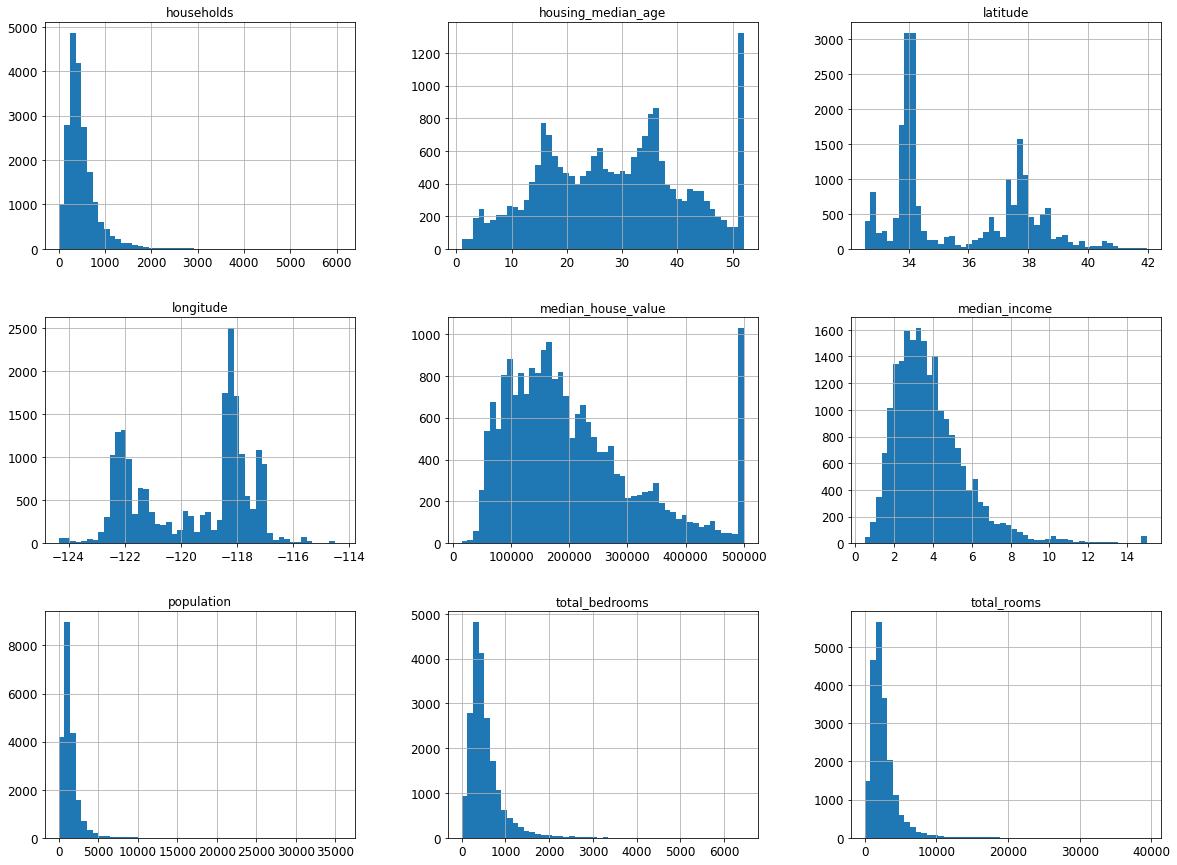

In [9]:
housing.hist(bins=50, figsize=(20,15));

---
El método `hist()` está basado en Matplotlib, que a su vez se basa en un backend gráfico para dibujar en tu pantalla. Así que antes de que podamos dibujar cualquier cosa, necesitamos especificar qué backend debería usar Matplotlib. La opción más simple es el comando mágico de Jupyter `%matplotlib inline`. Esto le dice a Jupyter que configure Matplolib para que use el propio backend de Jupyter. Los gráficos serán renderizados dentro del notebook en si mismo. Tengamos en cuenta que llamar a `show()`es opcional en un notebook de Jupyter, ya que Jupyter mostrará automáticamente los gráficos cuando se ejecuta la celda.

---

Tengamos en cuenta algunas cosas en estos histogramas:

1. En primer lugar el atributo `median_income` (ingresos medios) no está expresado en dólares (USD). Hablando con el equipo que recopiló los datos nos dicen que los datos fueron escalados y se limitaron a 15 (en realidad 15,0001) para ingresos medios altos y a 0,5 (en realidad 0,4999) para ingresos medios bajos. Los números representan aproximadamente decenas de miles de dólares (es decir, 3 significaría alrededor de 30.000\\$). Trabajar con atributos preprocesados es bastante común en Machine Learning y no es necesariamente un problema, pero debemos intentar comprender cómo se han computado los datos.

2. Otros atributos que se limitaros o caparon son `housing median age` (edad media de la vivienda) y `median house value` (valor medio de la vivienda). Este último puede ser un serio problema ya que es nuestro atributo *target* (nuestra etiqueta). Nuestro algoritmo de Machine Learning puede aprender que los precios no van más allá de este límite. Es importante conocer cómo se han computado estos datos porque afectarán al algoritmo de machine learning que seleccionemos. Necesitamos verificar con el equipo cliente (el equipo que usará las salidas de nuestro sistema) para ver si esto es un problema o no. Si nos dicen que sí son necesarias predicciones precisas más allá de 500.000\\$ tenemos dos opciones:

+ Recopilar los distritos para los que se ha "capado" este atributo.
+ Eliminar estos distritos del conjunto de entrenamiento (y también del conjunto de prueba, ya que nuestro sistema no debe evaluarse mal si predice valores más allá de 500.000\\$).

Finalmente, muchos histogramas son de "cola pesada" (*tail heavy*). Es decir, se extiende mucho más hacia la derecha de la mediana que hacia la izquierda. Esto puede complicar a los algoritmos de machine learning detectar patrones. Intentaremos transformar dichos atributos para obtener distribuciones más en forma de campana.

Espero que esto nos ayude a comprender mejor el tipo de datos con el que estamos tratando.

¡Un momento! Antes de seguir viendo los datos, necesitamos crear un conjunto de prueba, lo dejamos a un lado y no lo miramos nunca.

### Crear un conjunto de prueba

Puede sonar extraño reservar voluntariamente parte de los datos en esta etapa. Después de todo solo hemos echado un rápido vistado a los datos y seguramente deberíamos aprender muchos más antes de decidir qué algoritmo usar, ¿verdad? Esto es cierto, pero nuestro cerebro es un sistema increible de detección de patrones, lo que significa que es altamente propenso al sobreajuste: si observa el conjunto de prueba puede tropezar con algún patrón aparentemente interesante en los datos de prueba que nos conduzca a seleccionar un tipo particular de modelo de Machine Learning. Cuando calculemos el error de generalización usando el conjunto de prueba, nuestras estimaciones serán demasiado optimistas e implantaríamos un sistema que no se ejecutaría tan bien como esperamos. Esto se denomina sesgo de *espionaje de los datos* (data snooping).

Teóricamente, crear un conjunto de pruebas es bastante simple: elegimos instancias al azar, generalmente el 20% del conjunto de datos (o menos si nuestro conjunto de datos es muy grande), y luego los dejamos a un lado:

In [10]:
def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

Estonces podríamos usar esta función de esta forma:

In [11]:
train_set, test_set = split_train_test(housing, 0.2)
print(f"Tamaño del dataset de entrenamiento: {len(train_set)}")
print(f"Tamaño del dataset de prueba: {len(test_set)}")

Tamaño del dataset de entrenamiento: 16512
Tamaño del dataset de prueba: 4128


Bueno, esto funciona pero no es perfecto: si ejecutamos el programa de nuevo generará un conjunto de prueba diferente. Con el tiempo, podríamos ver todo el conjunto de datos completo (nosotros o nuestros algoritmos de Machine Learning), que es lo que queremos evitar.

Una solución es guardar el conjunto de prueba en la primera ejecución y cargarlo en las sucesivas ejecuciones. Otra opción es establecer una semilla generadora de números aleatorios (por ejemplo, `np.random.seed(42)`) antes de llamar a `np.random.permitation()`, para que siempre genere los mismos indices aleatorios. (A menudo veremos personas que establecen la semilla aleatoria en 42. Este número no tiene ninguna propiedad especial, aparte de ser La Respuesta a la Última Pregunta de la Vida, el Universo y Todo, de la novela Guía del Autoestopista Galáctico, de Douglas Adam (1979)).

Pero ambas soluciones no funcionarán la siguiente vez que obtengamos un conjunto de datos actualizado. Una solución típica es usar cada identificador de instancia para decidir si debe ir o no al conjunto de prueba (asumiendo que las instancias tienen un identificador único e inmutable). Por ejemplo, podríamos calcular el hash de cada identificador de instancia y poner esa instancia en el conjunto de prueba si el hash es menor o igual al 20% del valor máximo de hash. Esto nos asegura que el conjunto de prueba permanecerá consistente a través de múltiples ejecuciones, pero no contendrá ninguna instancia que estuviera previamente en el conjunto de entrenamiento. A continuación podemos ver una posible implementación:

In [12]:
from zlib import crc32

def test_set_check(identifier, test_ratio):
    return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2**32

def split_train_test_by_id(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

Desafortunadamente, el conjunto de datos de viviendas no tiene un identificador de columna. La solución más simple es usar el índice de fila como ID:

In [13]:
housing_with_id = housing.reset_index()  # añade una columna "index"
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "index")

Si usamos el indice de fila como identificador único, necesitaremos asegurarnos que los nuevos datos se añadan al final del conjunto de datos y que nunca se eliminen filas. Si esto no es posible entonces deberíamos usar características más estables para construir un identificador único. Por ejemplo, la latitud y longitud de un distrito garantizan ser estables por unos cuantos millones de años, por lo que podríamos combinarlos en un ID como se muestra:

In [14]:
housing_with_id["id"] = housing["longitude"] * 1000 + housing["latitude"]
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "id")

La información de ubicación es bastante "gruesa" y, como resultado, muchos distritos tendrán exactamente la misma identificación, por lo que terminarán en el mismo conjunto (prueba o entrenamiento). Esto introduce un sesgo de muestreo desafortunado.

Scikit-Learn proporciona algunas funciones para dividir conjuntos de datos en múltiples subconjuntos de varias maneras. La función más simple es `train_test_split`, qque hace básicamente lo mismo que la función `split_train_test` que definimos anteriormente, con un par de características adicionales. Primero, hay un parámetro `random_state` que le permite establecer una semilla generadora aleatoria como se explicó anteriormente y, segundo, podemos pasarle múltiples conjuntos de datos con un número idéntico de filas y los dividirá en los mismos índices (esto es muy útil, por ejemplo, si tenemos un DataFrame separado para las etiquetas).

In [15]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

print(f"Entrenamiento: {train_set.shape[0]}\nPrueba: {test_set.shape[0]}")

Entrenamiento: 16512
Prueba: 4128


In [16]:
test_set.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
20046,-119.01,36.06,25.0,1505.0,NaN,1392.0,359.0,1.6812,47700.0,INLAND
3024,-119.46,35.14,30.0,2943.0,NaN,1565.0,584.0,2.5313,45800.0,INLAND
15663,-122.44,37.80,52.0,3830.0,NaN,1310.0,963.0,3.4801,500001.0,NEAR BAY
20484,-118.72,34.28,17.0,3051.0,NaN,1705.0,495.0,5.7376,218600.0,<1H OCEAN
9814,-121.93,36.62,34.0,2351.0,NaN,1063.0,428.0,3.7250,278000.0,NEAR OCEAN


Hasta ahora hemos considerado métodos de muestreo puramente aleatorios. Esto generalmente está bien si nuestro conjunto de datos es lo suficientemente grande (especialmente en relación con el número de atributos), pero si no es así, se corre el riesgo de introducir un sesgo de muestreo significativo. Cuando una empresa de encuestas decide llamar a 1.000 personas para hacerles algunas preguntas, no solo eligen 1.000 personas al azar en una lista de teléfonos. Intentan asegurar que estas 1.000 personas son representativos de toda la población. Por ejemplo, la población de EEUU está compuesta por un 51,3% de mujeres y un 48,7% de hombres, por lo que una encuesta bien realizada trataría de mantener esta proporción en la muestra: 513 mujeres y 487 hombres. Esto se denomina *muestreo estratificado*: la población se divide en subgrupos homogéneos llamados *estratos* y se muestrea el número correcto de casos de cada estrato para garantizar que el conjunto de pruebas sea representativo de la población general. Si usáramos un muestreo puramente aleatorio, tendríamos aproximadamente el 12% de probabilidad de probar un conjunto de pruebas sesgado con menos del 49% de mujeres y más del 54% de mujeres. De cualquier forma, los resultados de la encuesta estarían significativamente sesgados.

Supongamos que hemos hablado con los expertos y nos dijeron que el ingreso medio es un atributo muy importante para predecir los precios promedio de las viviendas. Es posible que queramos asegurarnos de que el conjunto de pruebas sea representativo de las diversas categorías de ingresos en el conjunto de datos completo. Dado que el ingreso medio es un atributo numérico continuo, primero debe crear un atributo de categoría de ingreso. Veamos más de cerca el histograma de ingreso medio:

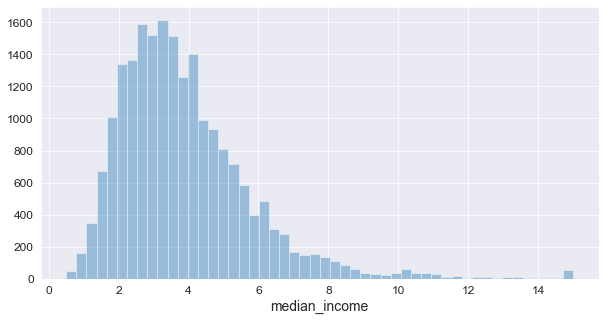

In [17]:
sns.set_style("darkgrid")
figure, axs = plt.subplots(figsize=(10,5))
sns.distplot(housing["median_income"], kde=False);

La mayoría de los valores de ingresos medios se agrupan alrededor de 1,5 a 6 (es decir, entre 15.000\\$ y 60.000\\$), pero algunos ingresos medios van mucho más allá de 6. Es importante tener un número suficiente de instancias en nuestro conjunto de datos para cada estrato, o si no la estimación de la importancia del estrato puede ser sesgada. Esto significa que no debemos tener demasiados estratos y cada estrato debe ser lo suficientemente grande. El siguiente código usa la función `pd.cut()`para crear un atributo de categoría de ingreso con 5 categorías (etiquetadas de 1 a 5): categoría 1 rangos entre 0 y 1,5 (es decir, menores de 15.000\\$), categoría 2 desde 1,5 a 3, y así sucesivamente:

In [18]:
housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])

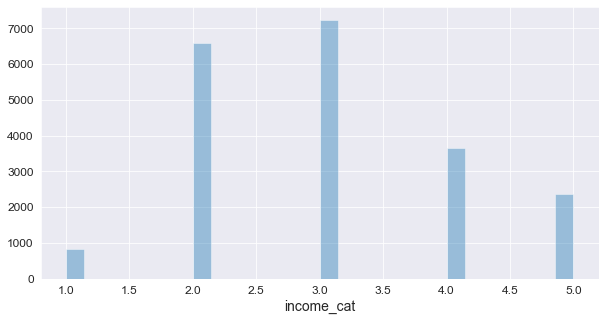

In [19]:
sns.set_style("darkgrid")
figure, axs = plt.subplots(figsize=(10,5))
sns.distplot(housing["income_cat"], kde=False);

Ahora ya podemos hacer muestreo estratificado basado en la categoría ingresos. Para ello usamos la clase de Scikit-Learn `StratifiedShuffleSplit`

In [20]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, text_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[text_index]


Veamos si ha funcionado como esperábamos. Empezaremos mirando las proporciones de la categoría de salarios en el conjunto de prueba:

In [21]:
strat_test_set["income_cat"].value_counts(normalize=True)

3    0.350533
2    0.318798
4    0.176357
5    0.114583
1    0.039729
Name: income_cat, dtype: float64

De igual manera revisamos el conjunto de entrenamiento:

In [22]:
strat_train_set["income_cat"].value_counts(normalize=True)

3    0.350594
2    0.318859
4    0.176296
5    0.114402
1    0.039850
Name: income_cat, dtype: float64

Vamos a comparar la proporción de la categoría ingresos en el conjunto de datos global, en el conjunto de pruebas con muestreo estratificado y en el conjunto de pruebas usando muestreo aleatorio puro.

In [23]:
def income_cat_proportions(data):
    return data["income_cat"].value_counts(normalize=True)

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

compare_props = pd.DataFrame({
    "Global": income_cat_proportions(housing),
    "Estratificado": income_cat_proportions(strat_test_set),
    "Aleatorio": income_cat_proportions(test_set),
}).sort_index()
compare_props["%error Estratificado"] = 100 * compare_props["Estratificado"] / compare_props["Global"] - 100
compare_props["%error Aleatorio"] = 100 * compare_props["Aleatorio"] / compare_props["Global"] - 100

compare_props

,Global,Estratificado,Aleatorio,%error Estratificado,%error Aleatorio
1,0.039826,0.039729,0.040213,-0.243309,0.973236
2,0.318847,0.318798,0.324370,-0.015195,1.732260
3,0.350581,0.350533,0.358527,-0.013820,2.266446
4,0.176308,0.176357,0.167393,0.027480,-5.056334
5,0.114438,0.114583,0.109496,0.127011,-4.318374


Podemos comprobar que el conjunto de pruebas usando muestreo estratificado tiene casi las mismas proporciones que el conjunto global, mientras que el conjunto de prueba generado mediante muestreo puramente aleatorio es bastante sesgado.

Ahora eliminamos el atributo `income_cat` para devolver el dataset a su estado original.

In [24]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

Pasamos bastante tiempo en la generación del conjunto de prueba por una buena razón: es una parte a menudo descuidada pero crítica de un proyecto de Machine Learning. Además, la mayoría de estas ideas serán útiles después cuando hablemos de la validación cruzada. Ahora es tiempo de pasar a la siguiente etapa: la exploración de los datos.

## Descubrir y visualizar los datos para obtener insights

Hasta ahora solo hemos echado un rápido vistazo a los datos para obtener una comprensión general del tipo de datos que estamos manipulando. Ahora el objetivo es ir un poco más en profundidad. Lo primero que debemos hacer es asegurarnos de dejar de lado el conjunto de datos de prueba y explorar solo el conjunto de entrenamiento. Además, si el conjunto de entrenamiento es muy grande, podriamos probar un conjunto de exploración, para hacer las manipulaciones más fácil y rápidamente. En nuestro caso, el conjunto es bastante pequeño así que podemos trabajar directamente en el conjunto completo. Vamos a crearnos una copia para que podamos jugar con ella sin perjudicar el conjunto de entrenamiento:

In [25]:
housing = strat_test_set.copy()

### Visualizando datos geográficos

Dado que existe información geográfica (latitud y longitud) es una buena idea crear un gráfico de puntos de todos los distritos para visualizar los datos:

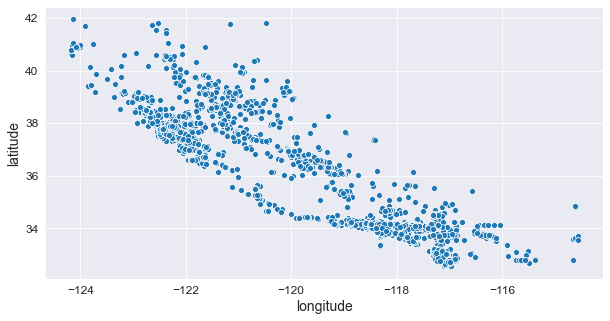

In [27]:
sns.set_style("darkgrid")
figure, axs = plt.subplots(figsize=(10,5))
ax = sns.scatterplot(x="longitude", y="latitude", data=housing)

Esto se parece a California, pero aparte de eso es difícil ver ningún patrón en particular. Estableciendo la opción `alpha` a `0.1` resultará muchos más fácil visualizar los lugares donde hay una alta densidad de puntos de datos:

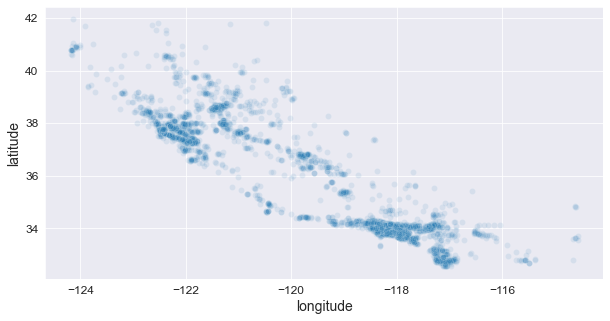

In [28]:
sns.set_style("darkgrid")
figure, axs = plt.subplots(figsize=(10,5))
ax = sns.scatterplot(x="longitude", y="latitude", data=housing, alpha=0.1)

Ahora está mucho mejor: podemos ver claramente las área de alta densidad, en Bay Area y alrededor de Los Angeles y San Diego, además de una larga línea de alta densidad en Central Valley, en paricular alrededor de Sacramento y Fresno.

Mas generalmente, nuestros cerebros son muy buenos en descubrir patrones en una fotografía, pero necesitamos jugar con los parámetros de visualización para hacer resaltar los patrones.

Ahora echemos un vistazo a los precios de las viviendas. El radio de cada círculo representa la población del distrito (opción `s`) y el color representa el precio (opción `c`). Usaremos un mapa de color predefinido (opción `cmap`) llamado `jet`, cuyos rangos van del azul (valores bajos) al rojo (precios altos).

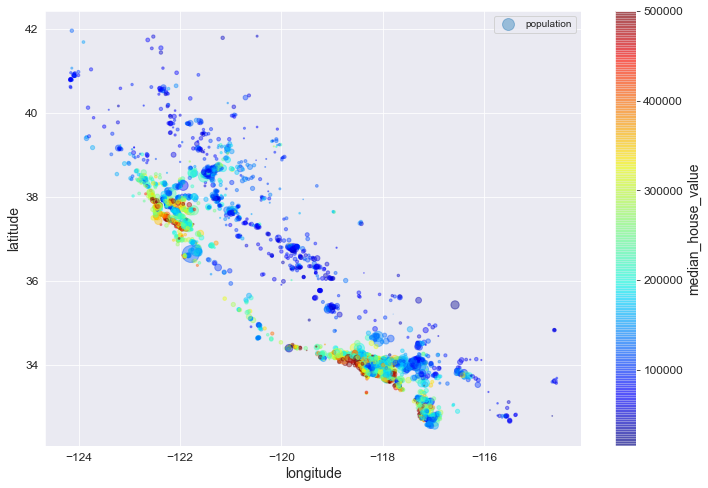

In [38]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
    s=housing["population"]/100, label="population", figsize=(12,8),
    c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
    sharex=False)
plt.legend();

Esta imagen nos dice que los precios de la vivienda están muy relacionados con la ubicación (por ejemplo, cerca del océano) y con la densidad de población, como probablemente ya sabíamos. Probablemente será útil utilizar un algoritmo de agrupación en clústeres para detectar los clústeres principales y agregar nuevas funciones que midan la proximidad a los centros de los clústeres. El atributo de proximidad al océano también puede ser útil, aunque en el norte de California los precios de las viviendas en los distritos costeros no son demasiado altos, por lo que no es una regla simple.

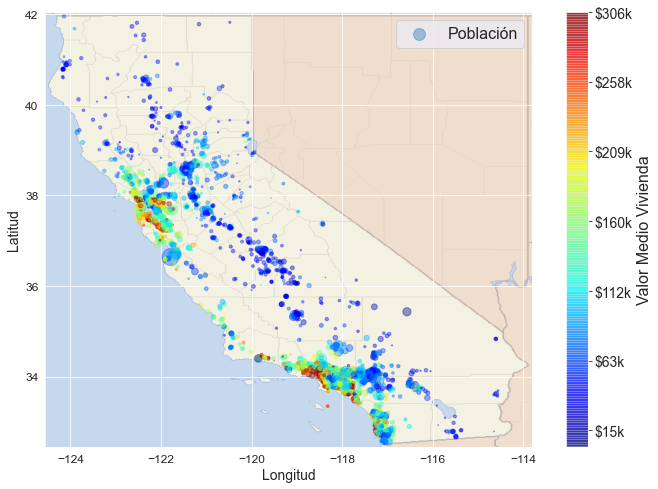

In [45]:
import matplotlib.image as mpimg
california_img=mpimg.imread('images/end_to_end_project/california.png')
ax = housing.plot(kind="scatter", x="longitude", y="latitude", figsize=(12,8),
                       s=housing['population']/100, label="Población",
                       c="median_house_value", cmap=plt.get_cmap("jet"),
                       colorbar=False, alpha=0.4,
                      )
plt.imshow(california_img, extent=[-124.55, -113.80, 32.45, 42.05], alpha=0.5,
           cmap=plt.get_cmap("jet"))
plt.ylabel("Latitud", fontsize=14)
plt.xlabel("Longitud", fontsize=14)

prices = housing["median_house_value"]
tick_values = np.linspace(prices.min(), prices.max(), 11)
cbar = plt.colorbar()
cbar.ax.set_yticklabels(["$%dk"%(round(v/1000)) for v in tick_values], fontsize=14)
cbar.set_label('Valor Medio Vivienda', fontsize=16)

plt.legend(fontsize=16)
plt.show()

### Buscando correlaciones

Dado que el dataset no es muy grande podemos calcular fácilmente el *coeficiente de correlación estándar* (también denominado *r de Pearson*) entre cada par de atributos haciendo uso del método `corr()`.

In [47]:
corr_matrix = housing.corr()

Ahora veamos cuáles son las correlaciones de cada atributo con el valor medio de la vivienda:

In [57]:
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.691831
total_rooms           0.131435
housing_median_age    0.071357
households            0.071242
total_bedrooms        0.057568
population           -0.016033
longitude            -0.039987
latitude             -0.150124
Name: median_house_value, dtype: float64

El coeficiente de correlación oscila entre –1 y 1. Cuando está cerca de 1, significa que existe una fuerte correlación positiva; por ejemplo, el valor medio de la vivienda tiende a subir cuando el ingreso medio aumenta. Cuando el coeficiente está cerca de -1, significa que existe una fuerte correlación negativa. Puede verse una pequeña correlación negativa entre la latitud y el valor medio de la casa (es decir, los precios tienen una ligera tendencia a bajar cuando se va al norte). Finalmente, los coeficientes cercanos a cero significan que no hay una correlación lineal. A continuación se muestran varios gráficos junto con el coeficiente de correlación entre sus ejes horizontal y vertical.

![Correlation_examples.png](images/ch02/Correlation_examples.png)

El coeficiente de correlación solo mide las correlaciones lineales ("si `x` sube entonces `y` generalmente sube / baja"). Es posible que se pierda completamente las relaciones no lineales (por ejemplo, "si `x` está cerca de cero, entonces `y` generalmente aumenta"). Observemos cómo todas las gráficas de la fila inferior tienen un coeficiente de correlación igual a cero, a pesar del hecho de que sus ejes claramente no son independientes: estos son ejemplos de relaciones no lineales. Además, la segunda fila muestra ejemplos en los que el coeficiente de correlación es igual a 1 o –1: esto no tiene nada que ver con la pendiente. Por ejemplo, nuestra altura en pulgadas tiene un coeficiente de correlación de 1 con nuestra altura en pies o en nanómetros.

Otra forma de verificar la correlación entre atributos es usar la función `scatter_matrix` de Pandas (o `pairplot` de seaborn), que dibuja cada atributo numérico contra cada otro atributo numérico. Dado que existen 11 atributos numéricos obtendríamos 11$^2$=121 gráficos, que no cabrían en una página, así que nos centraremos en unos cuantos atributos prometedores que parecen tener mayor correlación con el valor medio de la vivienda:

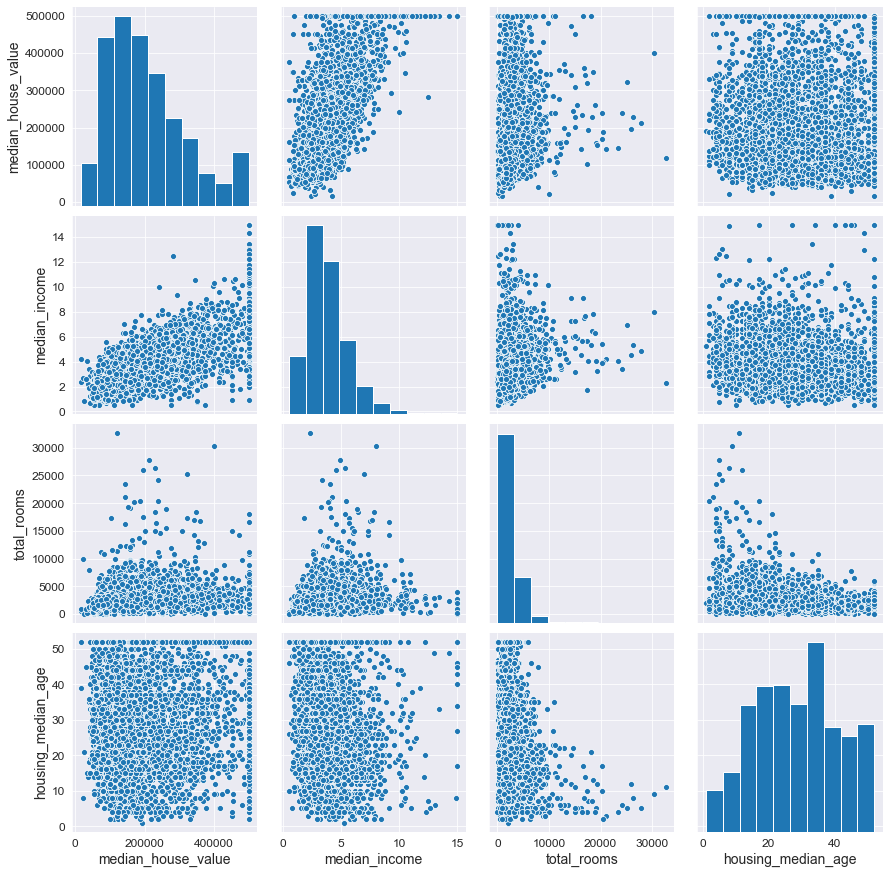

In [53]:
attributes = ["median_house_value", "median_income", "total_rooms","housing_median_age"]
sns.pairplot(housing[attributes], height=3);

La diagonal principal (esquina superior izquiera a inferior derecha) estaría repleta de líneas rectas si se dibujara cada variable consigo misma, por lo que nos sería útil. En su lugar, se muestra el histograma de cada atributo (aunque hay otras opciones).

El atributo más prometedor para predecir el valor medio de la vivienda es el ingreso medio, así que hagamos zoom en su diagrama de dispersión:

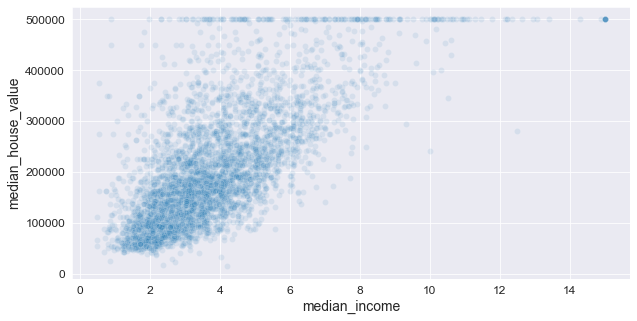

In [54]:
sns.set_style("darkgrid")
figure, axs = plt.subplots(figsize=(10,5))
ax = sns.scatterplot(x="median_income", y="median_house_value", data=housing, alpha=0.1)

Detectamos varias cosas en este gráfico. Primero, la correlación es de hecho muy fuerte; se puede ver claramente la tendencia alcista y que los puntos no están muy dispersos. Segundo, el límite de precio que notamos anteriormente es claramente visible como una línea horizontal a 500.000\\$. Pero esta gráfica revela otras líneas rectas menos obvias: una línea horizontal alrededor de 450.000\\$, otra alrededor de 350.000\\$, tal vez una alrededor de 280.000\\$, y algunas más por debajo de eso. Podemos intentar eliminar los distritos correspondientes para evitar que sus algoritmos aprendan a reproducir estas peculiaridades de los datos.

### Experimentando con la combinación de atributos

Las secciones anteriores nos dieron una idea de algunos caminos en los que podemos explorar y obtener ideas o insights. Hemos identificado algunas peculiaridades de los datos que podemos querer limpiar antes de proporcionarle datos al algoritmo de Machine Learning y encontramos correlaciones interesantes entre atributos, en particular con el atributo objetivo. También nos dimos cuenta que algunos atributos tendían una distribución de cola pesada, así que podríamos querer transformarlos (es decir, calculando su logaritmo). Por supuesto, nuestra trayectoria variará considerablemente con cada proyecto, pero las ideas generales son similares.

Una última cosa que podemos hacer antes de preparar realmente los datos para los algoritmos de machine learning es probar varias combinaciones de atributos. Por ejemplo, el número total de habitaciones en un distrito no es muy útil si no sabe cuántos hogares hay. Lo que realmente queremos es el número de habitaciones por hogar. Del mismo modo, el número total de dormitorios por sí solo no es muy útil: probablemente queramos compararlo con la cantidad de habitaciones. Y la población por hogar también parece ser una combinación de atributos interesante a considerar. Vamos a crear estos nuevos atributos.

In [56]:
housing["rooms_per_household"] = housing["total_rooms"] / housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"] / housing["total_rooms"]
housing["population_per_household"] = housing["population"] / housing["households"]

Veamos ahora de nuevo la matriz de correlaciones:

In [59]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.691831
rooms_per_household         0.192575
total_rooms                 0.131435
housing_median_age          0.071357
households                  0.071242
total_bedrooms              0.057568
population                 -0.016033
longitude                  -0.039987
population_per_household   -0.135142
latitude                   -0.150124
bedrooms_per_room          -0.240362
Name: median_house_value, dtype: float64

Bueno, no está mal. El nuevo atributo `bedrooms_per_room` está mucho más relacionado con el valor medio de la casa que el número total de habitaciones o dormitorios. Al parecer, las casas con una proporción más baja de dormitorios/habitación tienden a ser más caras. La cantidad de habitaciones por hogar (`rooms_per_household`) también es más informativa que la cantidad total de habitaciones en un distrito; obviamente, cuanto más grandes son las casas, más caras son. 

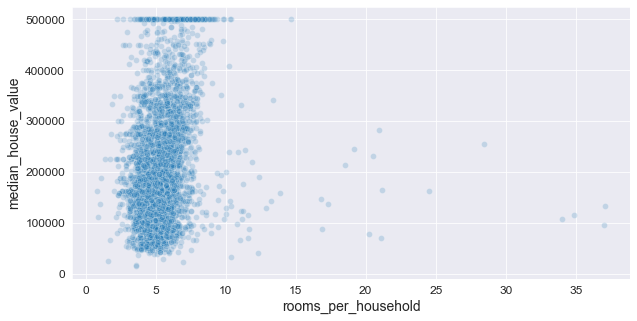

In [61]:
sns.set_style("darkgrid")
figure, axs = plt.subplots(figsize=(10,5))
ax = sns.scatterplot(x="rooms_per_household", y="median_house_value", data=housing, alpha=0.2)

Esta ronda de exploración no tiene que ser absolutamente exhaustiva; el punto es comenzar con el pie derecho y obtener rápidamente conocimientos que nos ayudarán a obtener un primer prototipo razonablemente bueno. Pero este es un proceso iterativo: una vez que se pone en marcha un prototipo, se puede analizar su salida para obtener más información y volver a este paso de exploración.

## Preparar los datos para los algoritmos de Machine Learning